<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_1022The_Annotated_%22Attention_is_All_You_Need%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# トランスフォーマー注釈

- [オリジナルブログ The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)
- [オリジナル Colab code](https://drive.google.com/file/d/1xQXSv6mtAOLXxEMi8RvaW8TW-7bvYBDF/view)
- [オリジナルブログの新バージョン](https://nlp.seas.harvard.edu/annotated-transformer/)
- [新バージョンの GitHub リポジトリ](https://nlp.seas.harvard.edu/annotated-transformer/)

- このファイル <https://drive.google.com/open?id=1naZHpTLgfLd54RcY4yi0WyQYoKf1yBBo>

- [他の実装も参照](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)

<center>
<img src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_0_0.png" width="49%">
</center>

私は教える際，機械学習の最近の動向を理解する方法として，実装を重視しています。
この投稿は， この目標に沿って自分を誠実に保つための試みです。
NIPS 2017 で発表された最近の [Attention is All You Need](https://arxiv.org/abs/1706.03762) 論文は， 機械翻訳や 潜在的に自然言語処理 全般の新しい手法として， 瞬く間にインパクトのある論文となりました。
この論文は非常にわかりやすく書かれていますが， これまでの常識では， 正しく実装するのはかなり難しいとされてきました。

> この投稿では， 論文の最初から最後までを追い， 各構成要素をコードで実装してみました。
(元の論文から若干の順序変更やスキップをしています)。
この文書自体が作業用のノートであり， 完全に使用可能で効率的な実装であるべきです。
[PyTorch](http://pytorch.org/) と [torchtext](https://github.com/pytorch/text) をインストールする必要があります。
完全なコードは [github](https://github.com/harvardnlp/annotated-transformer) にあります。
> - Alexander "Sasha" Rush ([@harvardnlp](https://twitter.com/harvardnlp))


`Attention is All You Need` の Transformer は，昨年から多くの人の心をとらえている。
翻訳品質の大幅な向上に加え，他の多くの NLP 課題に新しいアーキテクチャを提供している。
この論文自体は非常にわかりやすく書かれていますが，正しく実装するのはかなり難しいというのがこれまでの常識であった。
<!-- The Transformer from “Attention is All You Need” has been on a lot of people’s minds over the last year. 
Besides producing major improvements in translation quality, it provides a new architecture for many other NLP tasks. 
The paper itself is very clearly written, but the conventional wisdom has been that it is quite difficult to implement correctly.
-->

この投稿では，この論文の「注釈付き」バージョンを，一行ごとの実装という形で紹介する。
元論文からいくつかの節を並べ替えたり削除したりし，全体的にコメントを追加している。
この文書自体はワーキングノートであり，完全に使用可能な実装である。
合計で 400 行のライブラリコードがあり，4 つの GPU で 1 秒間に 27,000 トークンを処理することができる。
<!-- In this post I present an “annotated” version of the paper in the form of a line-by-line implementation. 
I have reordered and deleted some sections from the original paper and added comments throughout. 
This document itself is a working notebook, and should be a completely usable implementation. 
In total there are 400 lines of library code which can process 27,000 tokens per second on 4 GPUs.
-->

Alexander Rush (@harvardnlp or srush@seas.harvard.edu), with help from Vincent Nguyen and Guillaume Klein


In [1]:
%config InlineBackend.figure_format = 'retina'
import torch
try:
    import bit
except ImportError:
    !pip install ipynbname --upgrade
    !git clone https://github.com/ShinAsakawa/bit.git
import bit
isColab = bit.isColab
HOME = bit.HOME

日付: 2022-10-06
HOSTNAME: Leda
ユーザ名: asakawa
HOME: /Users/asakawa
ファイル名: study/2022komazawa-deep-learning_komazawa-deep-learning.github.io/2021notebooks/2022_0626Annotated_Attention_is_All_You_Need.ipynb
torch.__version__: 1.12.1


In [ ]:
# if isColab:
#     !pip install --upgrade pytorch torchtext numpy matplotlib spacy 

In [2]:
# 標準的な PyTorch 関連ライブラリの輸入
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

# 1. 背景

[Extended Neural GPU](https://arxiv.org/abs/1511.08228), [ByteNet](https://arxiv.org/abs/1610.10099), [ConvS2S](https://arxiv.org/abs/1705.03122) などのモデルでは，基本的な構成要素として畳み込みニューラルネットワークが用いられており，すべての入出力位置について隠れた表現を並列に計算している。
これらのモデルでは， 任意の 2 つの入出力位置からの信号を関連付けるために必要な演算の数は，位置間の距離に応じて ConvS2S では線形に，ByteNet では対数的に増加する。
このため，離れた位置間の依存関係を学習することが難しくなる。
トランスフォーマーでは，注目度の高い位置を平均化することで実効的な解像度が低下するが，これは以下の多頭注意機構によって相殺され，一定の演算数に抑えられる。

自己注意 (イントラ注意と呼ばれることもある) は 1 つの配列の異なる位置を関連づけて，その配列の表現を計算するための注意機構である。
自己注意は，読解，抽象的な要約，テキストの含意，課題に依存しない文の表現の学習など，さまざまな課題で利用されています。
エンド=2=エンド (煩雑な前処理や後処理が不要) の メモリネットワークは，配列に沿った再帰ではなく，再帰的な注意機構に基づいており，簡易な言語の質問応答や言語モデルの課題で優れた性能を発揮することが示されている。

しかし，我々の知る限り，トランスフォーマーは，配列を揃えた RNN や畳み込みを使用せずに，自己注意に完全に依存して入力と出力の表現を計算する初めての伝達モデル (transduction model) である。

# 2. モデル構成

ほとんどの競合するニューラルネットワーク トランスファーモデルは， 符号化器-復号化器構造を持っています[(Bahdanau2014)](https://arxiv.org/abs/1409.0473)
<!-- (cho2014learning,bahdanau2014neural,sutskever14)。 -->
ここで，符号化器は， 入力された記号表現の列 $(x_1, ..., x_n)$ を連続表現の列 $\mathbf{z} = (z_1, ..., z_n)$ にマッピングします。
復号化器は $\mathbf{z}$ が与えられると，1 要素ずつ記号の出力系列 $(y_1,...,y_m)$ を生成します。
各ステップにおいて， モデルは自己回帰的に [(Graves2013)](https://arxiv.org/abs/1308.0850) 次の記号を生成する際に， 前に生成された記号を追加入力として消費します。

In [125]:
class EncoderDecoder(nn.Module):
    """典型的な 符号化器-復号化器 アーキテクチャ 基本モデル"""
    
    def __init__(self, 
                 encoder:nn.Module, 
                 decoder:nn.Module, 
                 src_embed:nn.Module, 
                 tgt_embed:nn.Module, 
                 generator:nn.Module):
        
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, 
                src:torch.Tensor, 
                tgt:torch.Tensor, 
                src_mask:torch.Tensor, 
                tgt_mask:torch.Tensor):
        """マスク付きの ソース系列 と ターゲット系列を用いて処理"""
        return self.decode(self.encode(src, src_mask), src_mask, 
                           tgt, tgt_mask)
    
    def encode(self, 
               src:torch.Tensor, 
               src_mask:torch.Tensor):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, 
               memory:torch.Tensor, 
               src_mask:torch.Tensor, 
               tgt:torch.Tensor, 
               tgt_mask:torch.Tensor):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


In [126]:
class EncoderDecoder_old(nn.Module):
    """典型的な 符号化器-復号化器 アーキテクチャ 基本モデル"""
    def __init__(self, 
                 encoder:nn.Module, 
                 decoder:nn.Module, 
                 src_embed:nn.Module, 
                 tgt_embed:nn.Module, 
                 generator:nn.Module):
        
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, 
                src, 
                tgt, 
                src_mask, 
                tgt_mask):
        """マスク化ソース `src` と目的系列を取り込み処理"""
        memory = self.encoder(self.src_embed(src), src_mask)
        output = self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        return output

トランスフォーマーは，この全体的なアーキテクチャに沿って，図 1 の左半分と右半分にそれぞれ示されているように，符号化器と復号化器の両方に，積層自己注意と点毎の完全連結層を使用している。

<center>
<img src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png" width="19%"><br/>
図 1. 
</center>

## 2.1 符号化器と復号化器の積層



### 2.1.1 符号化器: 

符号化器は $N=6$ 枚の同じ層の積み重ねで構成される。

In [127]:
def clones(module:nn.Module, N:int=1):
    """N 個の積層を作成するための関数。完全に同一な (identical) 層を複製"""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [128]:
class Encoder(nn.Module):
    """核となる符号化器 は N 層の積層"""
    
    def __init__(self, 
                 layer:nn.Module, 
                 N:int=1):
        
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, 
                x:nn.Module, 
                mask:nn.Module):
        """入力（とマスク）を各層に順番に通す"""
        
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

2 つの下位層それぞれの周りに **残差接続** [(He2015,ResNet)](https://arxiv.org/abs/1512.03385) を採用し，その後 **層正規化** [(LeiBa+2016)](https://arxiv.org/abs/1607.06450) を行う。

In [129]:
class LayerNorm(nn.Module):
    """層正規化モジュール  (詳細は原著 https://arxiv.org/abs/1607.06450)"""
    
    def __init__(self, 
                 features:int, 
                 eps:float=1e-6):
        
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

つまり，各下位層の出力は `LayerNorm(x + Sublayer(x))` となり，`Sublayer(x)` は下位層自身が実装する関数である。
各下位層の出力に **ドロップアウト**[(Srivastava+2014)](https://jmlr.org/papers/v15/srivastava14a.html) を適用してから，下位層の入力に加えて正規化する。 

これらの残差接続を容易にするために，モデル内のすべての下位層と埋め込み層は，次元 $d_{\text{model}}=512$ の出力を生成する。

In [130]:
class SublayerConnection(nn.Module):
    """正規化層に後続する残差接続
    コードを簡単にするために，ノルムを最後に適用するのではなく，最初に適用することに注意"""
    
    def __init__(self, 
                 size:int, 
                 dropout:float):
        super().__init__()
        self.norm = LayerNorm(features=size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, sublayer):
        """同一形状を維持するため，任意の SubLayer 関数に残差接続を適用"""
        return x + self.dropout(sublayer(self.norm(x)))

各層には 2 つの下位層がある。
1 つ目は多頭自己注意機構で，2 つ目は簡単な，位置ごと(point-wise) 完全連結フィードフォワードネットワークである。

In [131]:
class EncoderLayer(nn.Module):
    """符号化器は自己注意層とフィードフォワード (以下で定義) の 2 つの下位層で構成される"""
    
    def __init__(self, 
                 size:int, 
                 self_attn:nn.Module, 
                 feed_forward:nn.Module, 
                 dropout:float=0.1):
        super().__init__()
        
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), size)
        #self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, 
                x:nn.Module, 
                mask:nn.Module):
        """図 1 左 に従って接続"""
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### 2.1.2 復号化器:

また，復号化器は $N=6$ 個の同一の階層の積み重ねで構成される。

In [132]:
class Decoder(nn.Module):
    """マスク付き復号化器化の一般化 N 層"""
    
    def __init__(self, 
                 layer:nn.Module, 
                 N:int=1):
        super().__init__()
        self.layers = clones(module=layer, N=N)
        self.norm = LayerNorm(features=layer.size)
        
    def forward(self, 
                x:nn.Module, 
                memory:torch.Tensor, 
                src_mask:torch.Tensor, 
                tgt_mask:torch.Tensor):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

各符号化器層の 2 つの下位層に加えて，復号化器は 3 つ目の下位層を挿入し，符号化器の積層の出力に対して多頭注意を行う。
符号化器と同様，各下位層の周りに残差接続を採用し，その後，層正規化を行う。

In [133]:
class DecoderLayer(nn.Module):
    """復号化器は，`self-attn`, `src-attn`, フィードフォワード (以下で定義）の 3 つの下位層で構成される"""
    
    def __init__(self, 
                 size, 
                 self_attn, 
                 src_attn, 
                 feed_forward, 
                 dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, 
                x, 
                memory, 
                src_mask:torch.Tensor, 
                tgt_mask:torch.Tensor):
        """接続は図 1 右 に従う"""
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

また，復号化器積層の自己注意下位層を変更し，位置が後続の位置に注意を向けないようにする。
このマスクと，出力埋め込みが 1 位置分の離されていることを組み合わせることで，位置 $i$ の予測は，$i$ よりも小さい位置での既知の出力にのみ依存することが可能となる。

In [134]:
def subsequent_mask(size:int)->torch.Tensor:
    """後続位置のマスク"""
    
    attn_shape = (1, size, size)
    
    # `np.triu` 上三角行列，k 次の三角行列を得る
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    
    return torch.from_numpy(subsequent_mask) == 0

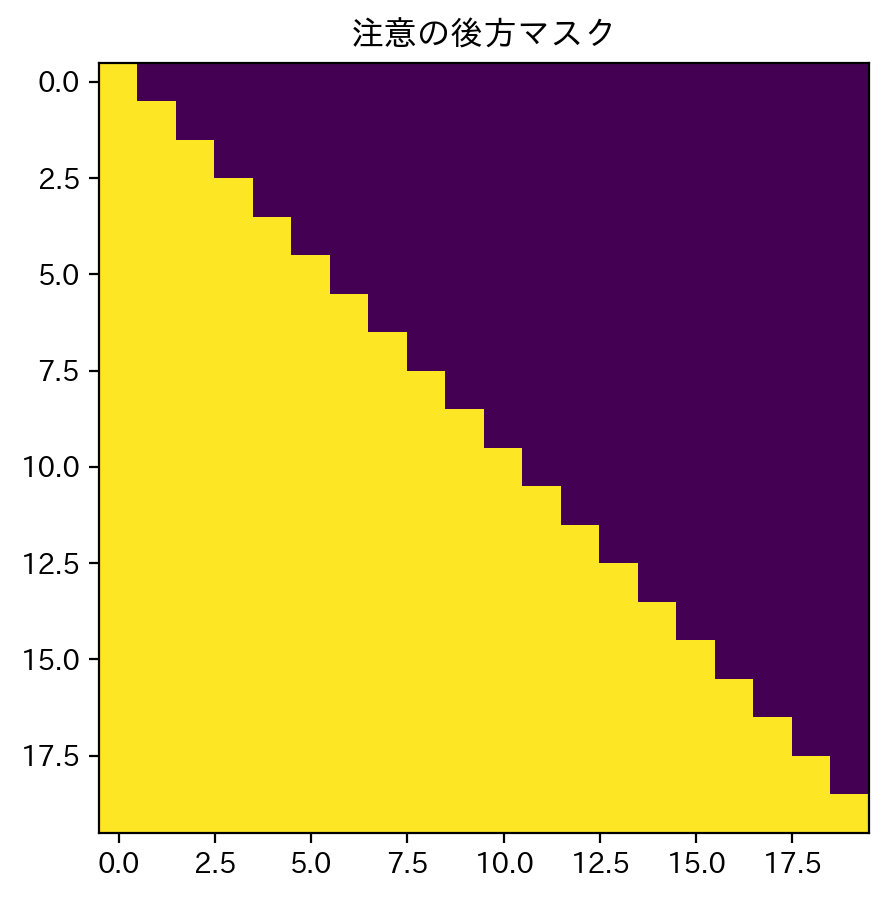

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1,

In [135]:
# 注意のマスクは，各目標単語 (行) が見ることを許される位置 (列) を示す。
# 単語は訓練中に将来の単語を注目するためにブロックされる。
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
plt.title('注意の後方マスク')
plt.show()
print(subsequent_mask(20)[0] * 1)

### 2.1.3 注意: 

注意関数は，クエリとキーと値の対となる出力に写像する。
クエリ，キー，バリュー，の出力はすべてベクトルである。
出力は，バリューの加重和として計算され，各バリューに割り当てられた重みは，クエリと対応するキーの互換性関数によって計算される。

この特別な注意を「規格化済み内積注意」と呼びことにする。
入力は $d_k$ 次元のクエリとキー，$d_v$ 次元のバリューとからなる。
クエリとすべてのキーの内積を計算し，それぞれを $\sqrt{d_k}$ で割り，ソフトマックス関数を適用して値の重みを求める。

<center>
<img width="09%" src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png"><br/>
</center>

実際には，行列 $Q$ にまとめられた一連のクエリに対して同時に注意関数を計算します。
キーとバリューも行列 $K$ と $V$ にまとめられる。
出力の行列を以下のように計算する:
                                                                 
$$ \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

In [136]:
def attention(query:torch.Tensor, 
              key:torch.Tensor, 
              value:torch.Tensor, 
              mask:torch.Tensor=None, 
              dropout:float=0.0)->torch.Tensor:
    """`規格化内積型注意の計算"""
    
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    
    # 以下で記述するドロップアウト
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

最も一般的に使用される 2 つの注意関数は， Bahdanau の加算型注意 [(Bahdanau2014)](https://arxiv.org/abs/1409.0473)と，Luong の 内積型 (乗算型) 注意である [(Loung+2014)](https://aclanthology.org/D15-1166/)。
内積型注意は，$\displaystyle\frac{1}{\sqrt{d_k}}$ という規格化因子を除いて，ここでのアルゴリズムと同じある。
加算型注意は，隠れ層が 1 つのフィードフォワードネットワークを使って互換性関数を計算する。
この 2 つは理論的な複雑さは類似しているが，内積型注意は，高度に最適化された行列乗算コードを用いて実装できるため，実際にはより高速で，よりスペース効率の高いものとなる。

$d_k$ の小さな値では 2 つの機構は同じような性能を発揮するが，$d_k$ が大きな値では規格化なしで加算的注意が内積注意を上回る [(Britz+2017)](https://arxiv.org/abs/1703.03906)。
$d_k$ の値が大きくなると，内積の大きさが大きくなり，ソフトマックス関数の勾配が極端に小さくなる領域に押し込まれるのではないかと考えられる (内積が大きくなる理由を説明するために，$q$ と $k$ の成分が平均 $0$, 分散 $1$ の独立した確率変数であると仮定。
そうすると，それらの内積である $\displaystyle q \cdot k = \sum_{i=1}^{d_k} q_ik_i$ は 平均 $0$, 分散 $d_k$ となる)。
この効果を打ち消すために，内積を $\displaystyle\frac{1}{\sqrt{d_k}}$ で規格化する。

### 2.1.4 多頭注意 multi-head attention

$d_{\text{model}}$ 次元のキー，バリュー， クエリで単一の注意関数を実行する代わりに，クエリ，キー，バリューをそれぞれ $d_k$ 次元, $d_k$ 次元, $d_v$ 次元に異なる，学習した線形射影で $h$ 回投影することが有益であることがわかった。

これらの射影されたバージョンのクエリ，キー，バリューのそれぞれに対して，注意関数を並行して実行し，$d_v$ 次元の出力値を得る。
これらは連結され，再び射影され，最終的な値が得られる。

<center>
<img width="13%" src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png"><br/>
    図 2
</center>

多頭注意では，モデルは異なる位置にある異なる表現下位空間からの情報を共同で注目することができる。
単一注意では，平均化がこれを阻害する。

$$ \mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O $$

ここで，$\mathrm{head_i}=\mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)$

ここで，射影されるのは，パラメータ行列 $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ と $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$ である。

ここでは $h=8$ 個の並列注意層 (ヘッド) を採用している。
それぞれのヘッドには $d_k=d_v=d_{\text{model}}/h=64$ を使用する。
各ヘッドの次元が小さくなったことで，全体の計算コストは，全次元の単一注意の場合と同様になる。

In [137]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, 
                 h:int=8,          # ヘッド数
                 d_model:int=512,  # 埋め込み次元
                 dropout=0.1       # ドロップアウト率
                ):
        """モデル形状と頭の数を取り込み"""
        super().__init__()
        
        assert d_model % h == 0
        
        # d_v は常に d_k と等しいと仮定
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(
            in_features=d_model,
            out_features=d_model), 4)
        self.attn = None
        
    def forward(self, 
                query, 
                key, 
                value, 
                mask=None):
        """図 2 の実装"""
        
        if mask is not None:
            # 全 h ヘッドに同一マスクを適用
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) すべての線形投影を一括して行う d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) バッチ内のすべての投影されたベクトルに注意をかけます。
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) view  を使って “連結 concat” し 最終的に線形変換を適用する。 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### 2.1.5 本モデルにおける注意の応用

トランスフォーマーは， 多頭注意を 3 つの方法で使用している。


1. ｢符号化器-復号化器注意｣層では，クエリは前の復号化層から，メモリのキーとバリューとは符号化器の出力から来る。
これにより，復号化器のすべての位置が入力系列のすべての位置に注意することができる。
これは [(2016Wu_Google翻訳)](https://arxiv.org/abs/1609.08144) のような seq-2-seq モデルにおける典型的な符号化器・符号化器の注意機構を模倣している。

2. 符号化器は自己注意層を含む。自己注意層では，すべてのキー，バリュー，クエリは同じ場所，この場合，符号化器の前の層の出力から来る。
符号化器の各位置は，符号化器の前の層のすべての位置に注意することができる。

3. 同様に，復号化器の自己注意層は，復号化器内の各位置が，その位置までの復号化器内のすべての位置に注意することを可能にする。
自己回帰性を維持するために，復号化器内の左向きの情報フローを防ぐ必要がある。
ソフトマックスの入力のうち，不正な接続に対応する全ての値をマスクする (-∞ に設定する) ことにより，規格化内積型注意の内部でこれを実装する。

## 2.2 位置毎 (point-wise) 順向ネットワーク

注意下位層に加えて，符号化器と復号化器の各層には，完全結合のフィード・フォワード・ネットワークが含まれており，これは各位置に個別かつ同一に適用される。
このネットワークは，ReLU 活性化を挟んだ 2 つの線形変換で構成される。

$$ \mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2 $$                                                                                      

線形変換は，異なる位置では同じだが，層ごとに異なるパラメータを使用する。
これを別の表現で表すと，カーネルサイズ 1 の 2 つの畳み込みとなる。
入出力の次元は $d_{\text{model}}=512$ であり，内部層の次元は $d_{ff}=2048$ である。

In [138]:
class PositionwiseFeedForward(nn.Module):
    """完全結合ネットワーク FFN 式の実装"""
    
    def __init__(self, 
                 d_model, 
                 d_ff, 
                 dropout=0.1):
        super().__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 2.3 埋め込みとソフトマックス

他の系列変換モデルと同様に，学習済み埋め込み層を用いて，入力トークンと出力トークンを次元 $d_{\text{model}}$ のベクトルに変換する。
また，復号化器の出力を次のトークンの予測確率に変換するために，通常の学習した線形変換とソフトマックス関数を使用する。
我々のモデルでは [(PressWolf2016)](https://arxiv.org/abs/1608.05859) と同様に，2 つの埋め込み層と事前ソフトマックス線形変換の間で同じ重み行列を共有している。
埋め込み層では，その重みに $\sqrt{d_{\text{model}}}$ を掛ける。

<!-- Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension d_model. 
We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. 
In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to (cite). 
In the embedding layers, we multiply those weights by √d_model. -->

In [139]:
class Embeddings(nn.Module):
    def __init__(self, 
                 d_model:int, 
                 vocab:int):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 2.4 位置符号化器

モデルには再帰も畳み込みもないので，モデルが系列の順序を利用するためには，系列内のトークンの相対的または絶対的な位置に関する何らかの情報を注入する必要がある。
そのために，符号化器と復号化器の積層の底部にある入力埋め込みに「位置符号化器」を追加する。
位置符号化器は埋め込みと同一次元 $d_{\text{model}}$ であり，2 つの埋め込みの和が取れるようになっている。
位置符号化器には学習型と固定型の多くの選択肢がある [(JonasFaceNet2017)](https://arxiv.org/abs/1705.03122)。

ここでは，異なる周波数の正弦波(サイン)と 余弦波 (コサイン) 関数を使用している。

$$
PE_{(\text{pos},2i)}   = \sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right)\\
PE_{(\text{pos},2i+1)} = \cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

ここで $pos$ は位置，$i$ は次元を表す。
つまり，位置情報の各次元は，正弦波に対応している。
波長は，$2\pi$ から $10000\cdot 2\pi$ へと幾何学的に変化していく。
この関数を選んだのは，任意の固定ズレ $k$ に対して $PE_{\text{pos}+k}$ は $PE_{\text{pos}}$ の一次関数として表現できるため，モデルが相対的な位置による注意を容易に学習できるのではないかと考えたからである。

さらに，符号化積層と復号化積層の両方で，埋め込みと位置符号化の合計にドロップアウトを適用する。
ベースモデルでは $P_{drop}=0.1$ の割合を使用している。

In [140]:
class PositionalEncoding(nn.Module):
    """一符号化器の実装"""
    def __init__(self, 
                 d_model:int=512, 
                 dropout:float=0.1, 
                 max_len=5000):
        
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # 対数空間における位置符号化ベクトルの一度計算しておく
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # `register_buffer` パラメータではないがモジュールの状態の一部であるべきテンソルを指定。
        # モジュールと同じデバイス上にある必要のあるテンソルに使用される
        # `persistent=False` はバッファの状態の辞書に追加しないように PyTorch に指示する (例えばモデルを保存する場合など)。
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

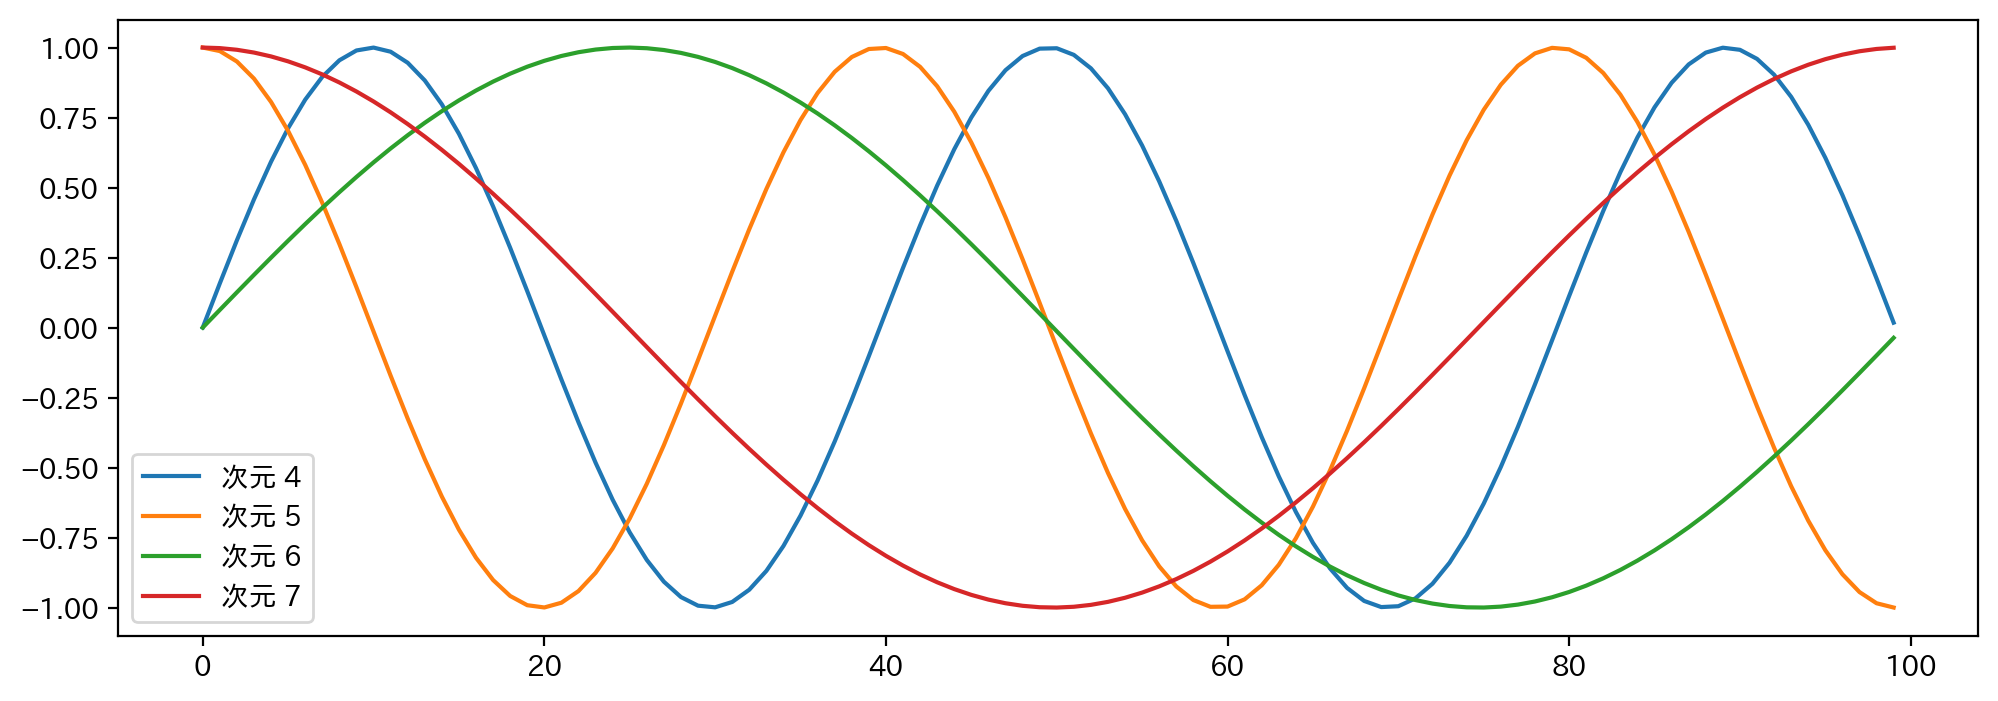

In [141]:
# 位置符号化器では，位置に応じて正弦波が加算される。
# 波の周波数とオフセット(ズレ) は，各次元で異なる。
plt.figure(figsize=(12, 4))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend([f"次元 {p}" for p in [4,5,6,7]])
#plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()
#None

また，学習した位置符号化 [(JonasFaceNet2017)](https://arxiv.org/abs/1705.03122) を代わりに使う実験も行った。
だが，2 つはほぼ同じ結果を得た。
正弦波版を選択したのは，学習時に遭遇したものよりも長い系列長にモデルを外挿することができるかもしれないからである。

## 2.5 生成

In [142]:
class Generator(nn.Module):
    """ベースとなる生成関数。(原著論文には記載なし)"""
    def __init__(self, 
                 d_model:int=512, 
                 vocab:int=32000):
        super().__init__()
        self.proj = nn.Linear(in_features=d_model,
                              out_features=vocab)

    def forward(self, x:torch.Tensor):
        return F.log_softmax(input=self.proj(x), dim=-1)

## 2.6 完全モデル

In [143]:
def make_model(src_vocab:int, 
               tgt_vocab:int, 
               N:int=6, 
               d_model:int=512, 
               d_ff:int=2048,
               h:int=8, 
               dropout:float=0.1):
    """ハイパーパラメータを指定したモデル構築のヘルパ関数"""
    
    c = copy.deepcopy
    
    attn = MultiHeadedAttention(
        h=h, 
        d_model=d_model, 
        dropout=dropout)
    
    ff = PositionwiseFeedForward(
        d_model=d_model, 
        d_ff=d_ff, 
        dropout=dropout)
    
    position = PositionalEncoding(
        d_model=d_model, 
        dropout=dropout)
    
    model = EncoderDecoder(
        encoder = Encoder(EncoderLayer(d_model, 
                                       c(attn), 
                                       c(ff), 
                                       dropout), 
                          N=N),
        decoder = Decoder(DecoderLayer(d_model, 
                                       c(attn), 
                                       c(attn), 
                                       c(ff), 
                                       dropout), 
                          N=N),
        src_embed = nn.Sequential(Embeddings(d_model, 
                                             src_vocab), 
                                  c(position)),
        tgt_embed = nn.Sequential(Embeddings(d_model, 
                                             tgt_vocab), 
                                  c(position)),
        generator = Generator(d_model=d_model, vocab=tgt_vocab))
    
    # 初期化はコード上，重要 (らしい。ブログによると)
    # Glorot (ザビエルの初期化) あるいは `fan_avg` でパラメータを初期化
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [144]:
# おもちゃモデルで評価
tmp_model = make_model(src_vocab=10, tgt_vocab=10, N=2)
tmp_model.eval();

# 3. 訓練

本節では，我々のモデルの訓練の体制について説明る。

ここでは、標準的な符号化器-復号化器モデルを学習するために必要な道具を簡単に解説する。
まず，学習用の ソース `src` 文と 目標 `target` 文を保持するバッチオブジェクトを定義し，マスクを作成する。

## 3.1 学習データとバッチ処理

<!-- 約 450 万の文対からなる標準的な WMT 2014 英独データセットで学習を行いました。
文は バイトペアエンコーディング cite{DBLP:journals/corr/BritzGLL17} を用いて符号化されており，約 37000 トークンのソース-ターゲット語彙が共有されています。
英仏語については，3600 万文からなるかなり大規模な WMT2014 英仏語データセットを使用し，トークンを 32000 語ピースの語彙に分割しました [(cite)](wu2016google)。
-->

<!-- 文の対は，おおよその配列の長さごとにまとめられました。
各学習バッチには，約 25000 個のソーストークンと約 25000 個のターゲットトークンを含む文対のセットが含まれています。 -->

## 3.2 ハードウェアとスケジュール

<!-- 8 台の NVIDIA P100 GPU を搭載した 1 台のマシンでモデルの学習を行いました。
本稿で紹介したハイパーパラメータを用いた基本モデルでは，各訓練ステップに約 0.4 秒かかりました。
ベースモデルの学習には，合計 100,000 ステップ，12 時間を要しました。
ビッグモデルの場合，ステップタイムは 1.0 秒でした。
大規模モデルは 300,000 ステップ (3.5 日) の訓練を行いました。 -->

## 3.3 最適化

Adam 最適化 [(kingma2014adam)](https://arxiv.org/abs/1412.6980) を使用し $\beta_1=0.9$, $\beta_2=0.98$, $\epsilon=10^{-9}$ とした。
学習の過程で学習率を式にしたがって変化させた。

$$
\text{lrate} = d_{\text{model}}^{-0.5} \cdot \min({\text{step_num}}^{-0.5}, 
(\text{step_num} \cdot {\text{warmup_steps}}^{-1.5}) $$

これは、最初の $\text{warmup_steps}$ の学習ステップでは学習率を線形に増加させ，その後はステップ数の逆平方根に比例して学習率を減少させることに相当する。
ここでは $\text{warmup_steps}=4000$ とした。

In [145]:
# 注: この部分は非常に重要。
# モデルが非常に不安定な場合は，このセットアップで訓練する必要がある。
class NoamOpt:
    """rate を実装した最適化関数のラッパー"""
    
    def __init__(self, 
                 model_size, 
                 factor, 
                 warmup, 
                 optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        """パラメータと rate の更新"""
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        """上記 `lrate` の実装"""
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), 
                             lr=0, 
                             betas=(0.9, 0.98), 
                             eps=1e-9))

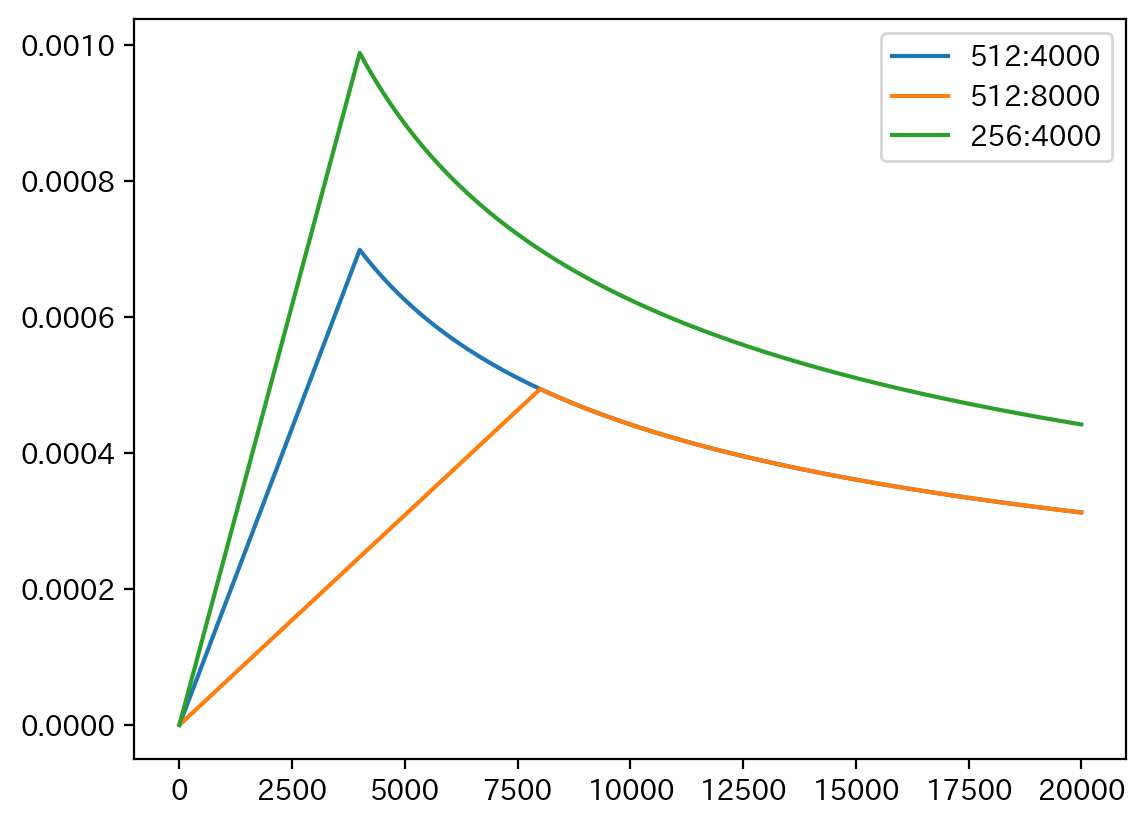

In [146]:
# ハイパーパラメータ `lrate` の 3 つの設定
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
plt.show()
#None

## 3.4 正則化



### 3.4.1 ラベル平滑化

学習時には，$\epsilon_{ls}=0.1$ [(Szegedy2015)](https://arxiv.org/abs/1512.00567) のラベル平滑化を採用した。
これは， モデルがより不確かになるように学習するため，パープレキシティ (錯乱度) を悪化させるが，精度と BLEU 得点を向上させる。

KL ダイバージェンス損失を用いてラベルの平滑化を行う。
ワンホットのターゲット分布ではなく，正解の確信度と残りの平滑化量を語彙全体に分散させた分布を作成。
<!-- We implement label smoothing using the KL div loss. 
Instead of using a one-hot target distribution, we create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary. -->

In [147]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

信頼度に応じた質量の単語への分配の例を見ることができる。
<!-- Here we can see an example of how the mass is distributed to the words based on confidence. -->

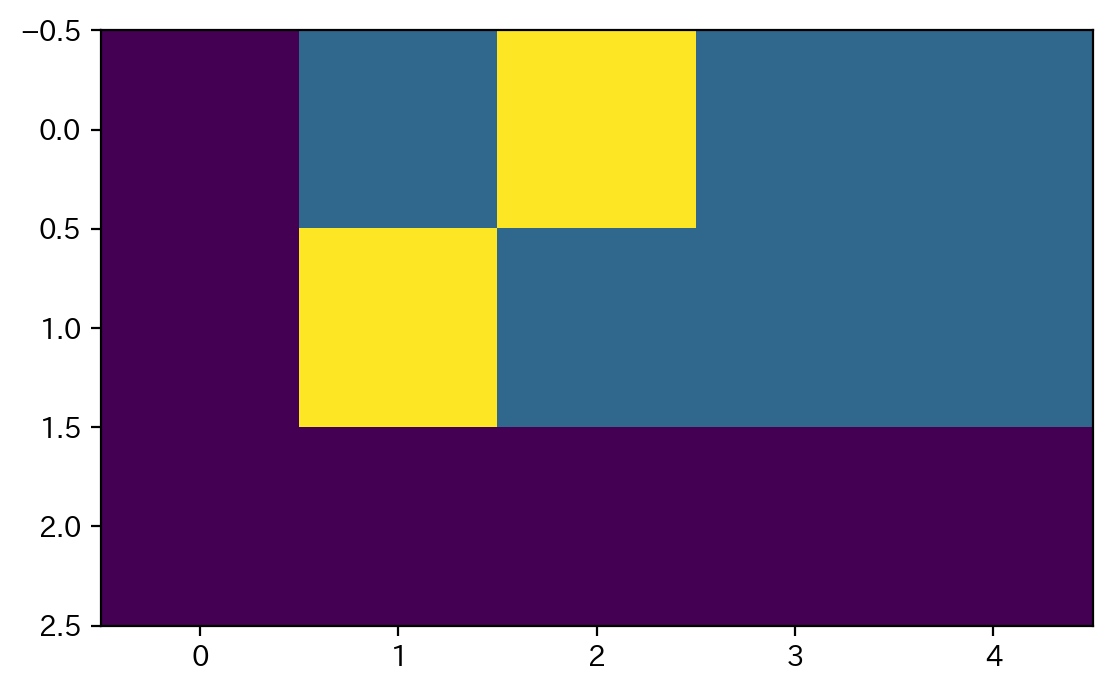

In [148]:
#Example
crit = LabelSmoothing(5, 0, 0.5)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# 系が期待する目標分布を表示
plt.imshow(crit.true_dist)
plt.show()
#None

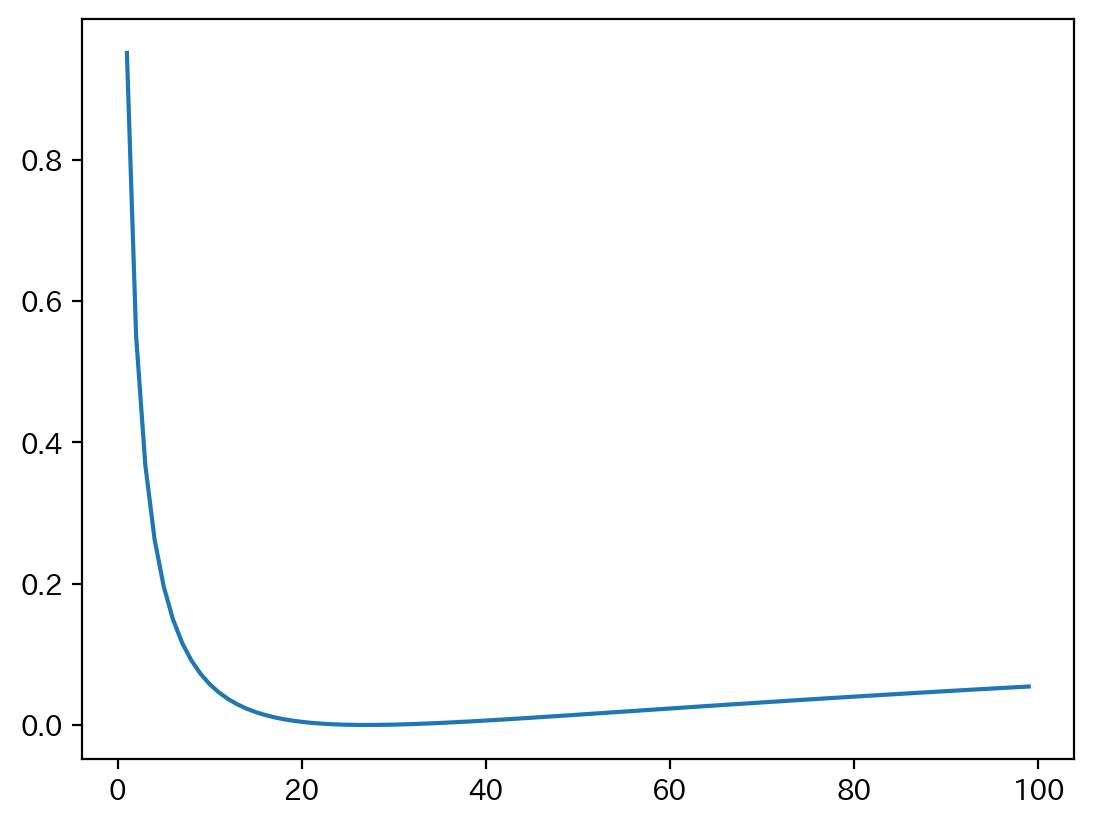

In [149]:
# 与えられた選択肢に非常に自信を持った場合
# ラベル平滑化はモデルにペナルティを与え始める 
crit = LabelSmoothing(5, 0, 0.1)
#crit = LabelSmoothing(5, 0, 0.2)

def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d], ])
    
    #print(predict.log())
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item() 

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

### 3.4.2 メモリ最適化

In [150]:
def loss_backprop(generator, criterion, out, targets, normalize):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.item()
        #total += loss.data[0]
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    out_grad = torch.stack(out_grad, dim=1)
    out.backward(gradient=out_grad)
    return total

In [151]:
def make_std_mask(src, tgt, pad):
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

In [152]:
def train_epoch(train_iter, model, criterion, opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
                        
        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 10 == 1:
            print(f'{i:5d}, loss:{loss:.3f}, model_opt._rate:{model_opt._rate:.4f}')

In [153]:
def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.test()
    total = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
        

In [154]:
class Batch:
    
    """学習時にマスクで一括してデータを保持するためのオブジェクト"""
    def __init__(self, 
                 src, 
                 trg, 
                 src_mask, 
                 trg_mask, 
                 ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens
    
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())

In [155]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = get_std_opt(model)
for epoch in range(2):
    train_epoch(data_gen(V, 30, 20), model, criterion, model_opt)

    1, loss:3.001, model_opt._rate:0.0000
   11, loss:2.801, model_opt._rate:0.0000
    1, loss:2.622, model_opt._rate:0.0000
   11, loss:2.394, model_opt._rate:0.0000


## A. 最初の例
<!-- ## A. A First Example-->

まず，簡単な複写課題を試してみよう。
小さな語彙からなるランダムな入力記号の集合が与えられたら，同じ記号を生成して返すことが目標である。
<!-- We can begin by trying out a simple copy-task. 
Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols. -->

#### A. Batches and Masking

In [156]:
class _Batch:
    """学習時にマスクで一括してデータを保持するためのオブジェクト"""
    
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

### A. Training Loop

In [157]:
import time
def run_epoch(data_iter, 
              model, 
              loss_compute)->torch.Tensor:
    """標準的な訓練とログ関数"""
    
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print(f"エポック ステップ: {i:3d} 損失: {loss/batch.ntokens:.3f} トークン数/秒: {tokens/elapsed:.3f}")
            # print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
            #         (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

### A.1 合成データ
<!-- ### Synthetic Data -->

In [158]:
def data_gen(V, 
             batch, 
             nbatches):
    """src-tgt 複写課題のためのランダムなデータを生成"""
    
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield _Batch(src, tgt, 0)

### A.2 損失の計算
<!-- #### Loss Computation -->

In [159]:
class SimpleLossCompute:
    """簡単な損失値の計算と学習関数"""
    
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm
        #return loss.data[0] * norm    

### A.3 貪欲復号化
<!-- ### A.3 Greedy Decoding -->

In [160]:
# 簡単な複写課題を訓練する
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(src_vocab=V, 
                   tgt_vocab=V, 
                   N=2)
model_opt = NoamOpt(
    model_size = model.src_embed[0].d_model, 
    factor=1, 
    warmup=400,
    optimizer=torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_iter=data_gen(V, 30, 20), 
              model=model, 
              loss_compute = SimpleLossCompute(
                  generator = model.generator, 
                  criterion=criterion, 
                  opt=model_opt))
    model.eval()
    print('\t\t検証損失: %.3f'%run_epoch(data_iter=data_gen(V, 30, 5), 
                                 model=model,
                                 loss_compute=SimpleLossCompute(
                                     generator=model.generator, 
                                     criterion=criterion,
                                     opt=None)).detach().numpy())

エポック ステップ:   1 損失: 2.942 トークン数/秒: 843.994
エポック ステップ:   1 損失: 1.878 トークン数/秒: 1062.557
		検証損失: 1.851
エポック ステップ:   1 損失: 1.991 トークン数/秒: 786.672
エポック ステップ:   1 損失: 1.691 トークン数/秒: 1065.660
		検証損失: 1.672
エポック ステップ:   1 損失: 1.860 トークン数/秒: 800.257
エポック ステップ:   1 損失: 1.513 トークン数/秒: 1074.569
		検証損失: 1.475
エポック ステップ:   1 損失: 1.562 トークン数/秒: 840.284
エポック ステップ:   1 損失: 1.177 トークン数/秒: 1032.482
		検証損失: 1.267
エポック ステップ:   1 損失: 1.426 トークン数/秒: 819.225
エポック ステップ:   1 損失: 0.795 トークン数/秒: 1007.893
		検証損失: 0.821
エポック ステップ:   1 損失: 1.048 トークン数/秒: 888.176
エポック ステップ:   1 損失: 0.553 トークン数/秒: 1097.468
		検証損失: 0.537
エポック ステップ:   1 損失: 0.711 トークン数/秒: 820.530
エポック ステップ:   1 損失: 0.285 トークン数/秒: 1052.966
		検証損失: 0.281
エポック ステップ:   1 損失: 0.974 トークン数/秒: 844.609
エポック ステップ:   1 損失: 0.273 トークン数/秒: 1020.879
		検証損失: 0.264
エポック ステップ:   1 損失: 0.354 トークン数/秒: 836.115
エポック ステップ:   1 損失: 0.217 トークン数/秒: 1091.419
		検証損失: 0.218
エポック ステップ:   1 損失: 0.324 トークン数/秒: 819.196
エポック ステップ:   1 損失: 0.381 トークン数/秒: 1079.905
		検証損失: 0.314


簡単のために貪欲復号化を用いて予測
<!-- This code predicts a translation using greedy decoding for simplicity. -->

In [161]:
def greedy_decode(model:nn.Module, 
                  src:torch.Tensor, 
                  src_mask:torch.Tensor, 
                  max_len:int, 
                  start_symbol:int):
    
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])


# 4. 実際例

In [ ]:
# # For data loading.
# from torchtext import data, datasets

In [ ]:
# if isColab:
#     !pip install torchtext spacy
#     !python -m spacy download en
#     !python -m spacy download de

以下は，torchtext が動作しないで fault する。

おそらく，allennlp や transformers などが用いられる理由が，このような `torchtext` の不安定さによるのだろう。
Huggeingface の transformers は普及しているし，通常の使い方ではこれで十分なように感じられる。
 

In [ ]:
# Load words from IWSLT

#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

import torchtext

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
#SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
SRC = torchtext.legacy.data.field(tokenize=tokenize_de, 
                                  lower=True, 
                                  pad_token=BLANK_WORD,
                                  init_token=BOS_WORD, 
                                  eos_token=EOS_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                 eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100
train, val, test = datasets.IWSLT.splits(exts=('.de', '.en'), fields=(SRC, TGT), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 1
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

In [ ]:
# Detail. Batching seems to matter quite a bit. 
# This is temporary code for dynamic batching based on number of tokens.
# This code should all go away once things get merged in this library.

BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

In [ ]:
# Create the model an load it onto our GPU.
pad_idx = TGT.vocab.stoi["<blank>"]
model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
model_opt = get_std_opt(model)
model.cuda()

In [ ]:

criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
    valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)


OTHER

In [ ]:
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field()
TGT = data.Field(init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD) # only target needs BOS/EOS

MAX_LEN = 100
train = datasets.TranslationDataset(path="/n/home00/srush/Data/baseline-1M_train.tok.shuf", 
                                    exts=('.en', '.fr'),
                                    fields=(SRC, TGT), 
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
SRC.build_vocab(train.src, max_size=50000)
TGT.build_vocab(train.trg, max_size=50000)

In [ ]:
pad_idx = TGT.vocab.stoi["<blank>"]
print(pad_idx)
model = make_model(len(SRC.vocab), len(TGT.vocab), pad_idx, N=6)
model_opt = get_opt(model)
model.cuda()

In [ ]:
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)
    valid_epoch()

In [ ]:
print(pad_idx)
print(len(SRC.vocab))

In [ ]:
torch.save(model, "/n/rush_lab/trans_ipython.pt")

In [ ]:
#weight = torch.ones(len(TGT.vocab))
#weight[pad_idx] = 0
#criterion = nn.NLLLoss(size_average=False, weight=weight.cuda())
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)

In [ ]:
1 10.825187489390373 6.987712429686844e-07
101 9.447168171405792 3.56373333914029e-05
201 7.142856806516647 7.057589553983712e-05
301 6.237934365868568 0.00010551445768827134
401 5.762486848048866 0.00014045301983670557
501 5.415792358107865 0.00017539158198513977
601 5.081815680023283 0.000210330144133574
701 4.788327748770826 0.00024526870628200823
801 4.381739928154275 0.0002802072684304424
901 4.55433791608084 0.00031514583057887664
1001 4.911875109748507 0.0003500843927273108
1101 4.0579032292589545 0.0003850229548757451
1201 4.2276234351193125 0.0004199615170241793
1301 3.932735869428143 0.00045490007917261356
1401 3.8179439397063106 0.0004898386413210477
1501 3.3608515430241823 0.000524777203469482
1601 3.832796103321016 0.0005597157656179162
1701 2.907085266895592 0.0005946543277663504
1801 3.5280659823838505 0.0006295928899147847
1901 2.895841649500653 0.0006645314520632189
2001 3.273784235585481 0.000699470014211653
2101 3.181488689899197 0.0007344085763600873
2201 3.4151616653980454 0.0007693471385085215
2301 3.4343731447588652 0.0008042857006569557
2401 3.0505455391539726 0.0008392242628053899
2501 2.8089329147478566 0.0008741628249538242
2601 2.7827929875456903 0.0009091013871022583
2701 2.4428516102489084 0.0009440399492506926
2801 2.4015486147254705 0.0009789785113991267
2901 2.3568112018401735 0.001013917073547561
3001 2.6349758653668687 0.0010488556356959952
3101 2.5981983028614195 0.0010837941978444295
3201 2.666826274838968 0.0011187327599928637
3301 3.0092043554177508 0.0011536713221412978
3401 2.4580375660589198 0.0011886098842897321
3501 2.586465588421561 0.0012235484464381662
3601 2.5663993963389657 0.0012584870085866006
3701 2.9430236657499336 0.0012934255707350347
3801 2.464644919440616 0.001328364132883469
3901 2.7124062888276512 0.0013633026950319032
4001 2.646443709731102 0.0013971932312809247
4101 2.7294750874862075 0.001380057517579748
4201 2.1295202329056337 0.0013635372009002666
4301 2.596563663915731 0.001347596306985731
4401 2.1265982036820787 0.0013322017384983986
4501 2.3880532500334084 0.0013173229858148
4601 2.6129120760888327 0.0013029318725783852
4701 2.2873719420749694 0.001289002331178292
4801 2.4949760700110346 0.0012755102040816328
4901 2.496607314562425 0.001262433067573089
5001 2.1889712483389303 0.0012497500749750088
5101 1.8677761815488338 0.0012374418168536253
5201 2.2992054556962103 0.0012254901960784316
5301 2.664361578106707 0.0012138783159049418
5401 2.705850490485318 0.0012025903795063202
5501 2.581445264921058 0.0011916115995949978
5601 2.2480602325085783 0.0011809281169581616
5701 1.9289666265249252 0.0011705269268863989
5801 2.4863578918157145 0.0011603958126073107
5901 2.632946971571073 0.0011505232849492607
6001 2.496141305891797 0.0011408985275576757
6101 2.6422974687084206 0.0011315113470699342
6201 2.448802186456305 0.0011223521277270118